# 0.0 Imports 

In [109]:
import re
import nltk
import spacy
import mglearn
import numpy as np
import en_core_web_sm
from spacy.tokens import Doc
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_files
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# 1.0 Load data from file

## 1.1 Train

In [2]:
reviews_train = load_files("data/aclImdb/train/")

In [3]:
text_train, y_train = reviews_train.data, reviews_train.target

## 1.2 Test

In [4]:
reviews_test = load_files("data/aclImdb/test/")

In [5]:
text_test, y_test = reviews_test.data, reviews_test.target

# 2.0 Describe the dataset

In [6]:
print("We have {} reviews in the train dataset and {} reviews in the test dataset.".format(len(text_train), len(text_test)))

We have 25000 reviews in the train dataset and 25000 reviews in the test dataset.


In [7]:
print("Samples per class (training): {}".format(np.bincount(y_train)[0:2]))

Samples per class (training): [12500 12500]


In [8]:
print("Samples per class (Test): {}".format(np.bincount(y_test)[0:2]))

Samples per class (Test): [12500 12500]


# 3.0 Pre-processing

In [9]:
text_train = [doc.replace(b"<br />", b" ") for doc in text_train] #Remove HTML tags

## 3.1 An example of the transformation from text to bag-of-words

In [10]:
bards_words =["The fool doth think he is wise,",
 "but the wise man knows himself to be a fool"]

In [11]:
vect = CountVectorizer()
vect.fit(bards_words)

CountVectorizer()

In [12]:
print("Vocabulary size: {}".format(len(vect.vocabulary_)))
print("Vocabulary content:\n {}".format(vect.vocabulary_))

Vocabulary size: 13
Vocabulary content:
 {'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 6, 'wise': 12, 'but': 1, 'man': 8, 'knows': 7, 'himself': 5, 'to': 11, 'be': 0}


In [13]:
bag_of_words = vect.transform(bards_words)

In [14]:
print("bag_of_words: {}".format(repr(bag_of_words)))


bag_of_words: <2x13 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>


In [15]:
print("Dense representation of bag_of_words:\n{}".format(
 bag_of_words.toarray()))


Dense representation of bag_of_words:
[[0 0 1 1 1 0 1 0 0 1 1 0 1]
 [1 1 0 1 0 1 0 1 1 1 0 1 1]]


## 3.2 Text to Bag-of-words

In [16]:
vect = CountVectorizer()
vect.fit(text_train)
X_train = vect.transform(text_train)

In [21]:
feature_names = vect.get_feature_names()
print("Total of features: {}\n".format(len(feature_names)))
print("First 50 features:\n{}".format(feature_names[:50]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 700th feature:\n{}".format(feature_names[::700]))


Total of features: 74849

First 50 features:
['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02', '020410', '029', '03', '04', '041', '05', '050', '06', '06th', '07', '08', '087', '089', '08th', '09', '0f', '0ne', '0r', '0s', '10', '100', '1000', '1000000', '10000000000000', '1000lb', '1000s', '1001', '100b', '100k', '100m']
Features 20010 to 20030:
['dratted', 'draub', 'draught', 'draughts', 'draughtswoman', 'draw', 'drawback', 'drawbacks', 'drawer', 'drawers', 'drawing', 'drawings', 'drawl', 'drawled', 'drawling', 'drawn', 'draws', 'draza', 'dre', 'drea']
Every 700th feature:
['00', '40s', 'accent', 'aforementioned', 'aloysius', 'annoucing', 'aristocratic', 'attired', 'bainter', 'bayonets', 'bersen', 'blaze', 'bookstores', 'brighton', 'bursting', 'capers', 'cbbc', 'chemstrand', 'clad', 'colin', 'condensing', 'coolidge', 'cray', 'cusp', 'dears', 'dempster', 'dialing', 'disl

# 4.0 The first model

In [17]:
scores = cross_val_score(LogisticRegression(n_jobs=-1, solver='sag', max_iter=10000), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}({:.2f})".format(np.mean(scores), np.std(scores)))

Mean cross-validation accuracy: 0.89(0.00)


### 4.1 Hyper-parameter optimization with the (slowly) Grid-Searh

In [18]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(n_jobs=-1, solver='sag', max_iter=10000), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.89
Best parameters:  {'C': 0.1}


### 4.2 Removing (most likely) useless words

In [22]:
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print("X_train with min_df: {}".format(repr(X_train)))

X_train with min_df: <25000x27271 sparse matrix of type '<class 'numpy.int64'>'
	with 3354014 stored elements in Compressed Sparse Row format>


In [23]:
feature_names = vect.get_feature_names()
print("Total of features: {}\n".format(len(feature_names)))
print("First 50 features:\n{}".format(feature_names[:50]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 700th feature:\n{}".format(feature_names[::700]))

Total of features: 27271

First 50 features:
['00', '000', '007', '00s', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '100th', '101', '102', '103', '104', '105', '107', '108', '10s', '10th', '11', '110', '112', '116', '117', '11th', '12', '120', '12th', '13', '135', '13th', '14', '140', '14th', '15', '150', '15th', '16', '160', '1600', '16mm', '16s', '16th']
Features 20010 to 20030:
['repentance', 'repercussions', 'repertoire', 'repetition', 'repetitions', 'repetitious', 'repetitive', 'rephrase', 'replace', 'replaced', 'replacement', 'replaces', 'replacing', 'replay', 'replayable', 'replayed', 'replaying', 'replays', 'replete', 'replica']
Every 700th feature:
['00', 'affections', 'appropriately', 'barbra', 'blurbs', 'butchered', 'cheese', 'commitment', 'courts', 'deconstructed', 'disgraceful', 'dvds', 'eschews', 'fell', 'freezer', 'goriest', 'hauser', 'hungary', 'insinuate', 'juggle', 'leering', 'maelstrom', 'messiah', 'music', 'occasional', 'parking', 'pl

### 4.3 Hyper-parameter optimization with the (slowly) Grid-Searh after removing many useless words

In [24]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(n_jobs=-1, solver='sag', max_iter=1000), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.89
Best parameters:  {'C': 1}


C:\Users\prove\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


### 4.4 Remove stopwords

In [26]:
print("Number of stop words: {}".format(len(ENGLISH_STOP_WORDS)))
print("Every 10th stopword:\n{}".format(list(ENGLISH_STOP_WORDS)[::10]))

Number of stop words: 318
Every 10th stopword:
['back', 'put', 'yet', 'mine', 'i', 'if', 'of', 'eight', 'sometimes', 'name', 'ever', 'thereupon', 'whoever', 'everything', 'via', 'otherwise', 'they', 'both', 'another', 'each', 'themselves', 'meanwhile', 'their', 'within', 'up', 'them', 'system', 'there', 'then', 'except', 'thence', 'was']


In [28]:
vect = CountVectorizer(min_df=5, stop_words='english').fit(text_train)
X_train = vect.transform(text_train)
print("X_train with stop words:\n{}".format(repr(X_train)))

X_train with stop words:
<25000x26966 sparse matrix of type '<class 'numpy.int64'>'
	with 2149958 stored elements in Compressed Sparse Row format>


In [29]:
grid = GridSearchCV(LogisticRegression(n_jobs=-1, solver='sag', max_iter=1000), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.88


### 4.5 Tf-idf Transformatiom (Term frequency-inverse document frequency)

This transformation assigns high weight to any term that appears often in a particular document, but not in many documents in the corpus. (https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

In [32]:
pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None), LogisticRegression(n_jobs=-1))
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.89


List features with the highest and lowest tf-idf values.

In [40]:
vectorizer = grid.best_estimator_.named_steps['tfidfvectorizer']
X_train = vectorizer.transform(text_train)
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
feature_names = np.array(vectorizer.get_feature_names())

print("Features with lowest tf-idf:\n{}".format(
 feature_names[sorted_by_tfidf[:20]]))
print("\nFeatures with highest tf-idf: \n{}".format(
 feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tf-idf:
['poignant' 'disagree' 'instantly' 'importantly' 'lacked' 'occurred'
 'currently' 'altogether' 'nearby' 'undoubtedly' 'directs' 'fond'
 'stinker' 'avoided' 'emphasis' 'commented' 'disappoint' 'realizing'
 'downhill' 'inane']

Features with highest tf-idf: 
['coop' 'homer' 'dillinger' 'hackenstein' 'gadget' 'taker' 'macarthur'
 'vargas' 'jesse' 'basket' 'dominick' 'the' 'victor' 'bridget' 'victoria'
 'khouri' 'zizek' 'rob' 'timon' 'titanic']


In [41]:
sorted_by_idf = np.argsort(vectorizer.idf_)
print("Features with lowest idf:\n{}".format(
 feature_names[sorted_by_idf[:100]]))

Features with lowest idf:
['the' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that' 'but' 'for' 'with'
 'was' 'as' 'on' 'movie' 'not' 'have' 'one' 'be' 'film' 'are' 'you' 'all'
 'at' 'an' 'by' 'so' 'from' 'like' 'who' 'they' 'there' 'if' 'his' 'out'
 'just' 'about' 'he' 'or' 'has' 'what' 'some' 'good' 'can' 'more' 'when'
 'time' 'up' 'very' 'even' 'only' 'no' 'would' 'my' 'see' 'really' 'story'
 'which' 'well' 'had' 'me' 'than' 'much' 'their' 'get' 'were' 'other'
 'been' 'do' 'most' 'don' 'her' 'also' 'into' 'first' 'made' 'how' 'great'
 'because' 'will' 'people' 'make' 'way' 'could' 'we' 'bad' 'after' 'any'
 'too' 'then' 'them' 'she' 'watch' 'think' 'acting' 'movies' 'seen' 'its'
 'him']


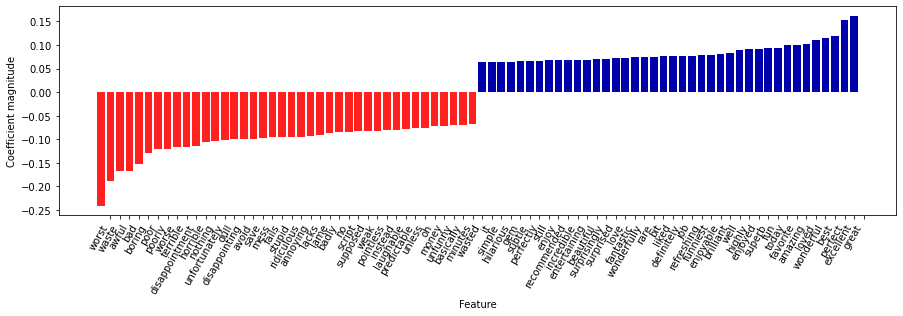

In [43]:
mglearn.tools.visualize_coefficients(
 grid.best_estimator_.named_steps["logisticregression"].coef_,
 feature_names, n_top_features=40)


### 4.6 n-Grams

In [46]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(n_jobs=-1, C=0.1))
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
             'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.91
Best parameters:
{'logisticregression__C': 100, 'tfidfvectorizer__ngram_range': (1, 3)}


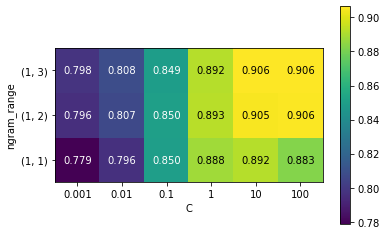

In [51]:
scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T

heatmap = mglearn.tools.heatmap(scores, xlabel="C", ylabel="ngram_range", cmap="viridis", fmt="%.3f",
xticklabels=param_grid['logisticregression__C'],
yticklabels=param_grid['tfidfvectorizer__ngram_range'])

plt.colorbar(heatmap);

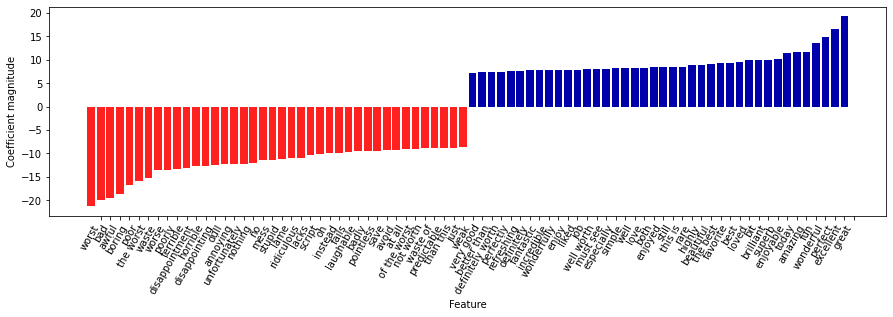

In [52]:
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)

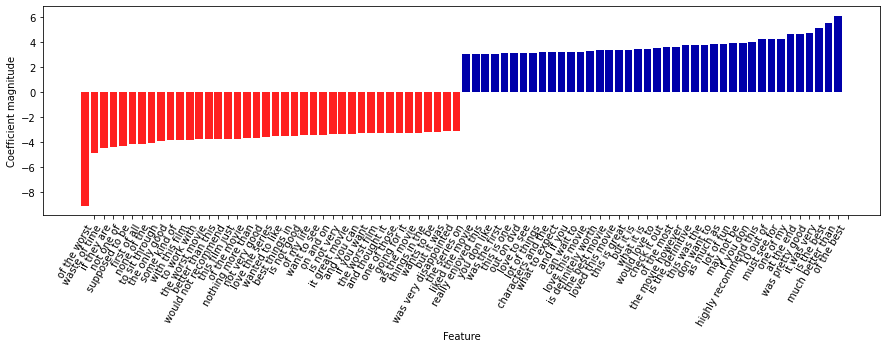

In [53]:
# find 3-gram features
mask = np.array([len(feature.split(" ")) for feature in feature_names]) == 3
# visualize only 3-gram features
mglearn.tools.visualize_coefficients(coef.ravel()[mask],
 feature_names[mask], n_top_features=40)

### 4.7 Advanced Tokenization, Stemming, and Lemmatization

In [61]:
def compare_normalization(doc):
    doc_spacy = en_nlp(doc)
    
    print("Lemmatization:")
    print([token.lemma_ for token in doc_spacy])

    print("Stemming:")
    print([stemmer.stem(token.norm_.lower()) for token in doc_spacy])

In [75]:
en_nlp = en_core_web_sm.load()
stemmer = nltk.stem.PorterStemmer()

In [78]:
compare_normalization(u"Our meeting today was worse than yesterday, "
 "I'm scared of meeting the clients tomorrow.")


Lemmatization:
['-PRON-', 'meeting', 'today', 'be', 'bad', 'than', 'yesterday', ',', '-PRON-', 'be', 'scared', 'of', 'meet', 'the', 'client', 'tomorrow', '.']
Stemming:
['our', 'meet', 'today', 'wa', 'wors', 'than', 'yesterday', ',', 'i', 'am', 'scare', 'of', 'meet', 'the', 'client', 'tomorrow', '.']


In [107]:
regexp = re.compile('(?u)\\b\\w\\w+\\b')

In [ ]:
en_nlp = en_core_web_sm.load()
old_tokenizer = en_nlp.tokenizer

en_nlp.tokenizer = lambda string: Doc(en_nlp.vocab, words = regexp.findall(string)) 

In [104]:
def custom_tokenizer(document):
    doc_spacy = en_nlp(document)
    return [token.lemma_ for token in doc_spacy]

In [105]:
lemma_vect = CountVectorizer(tokenizer=custom_tokenizer, min_df=5)

In [108]:
X_train_lemma = lemma_vect.fit_transform(text_train)
print("X_train_lemma.shape: {}".format(X_train_lemma.shape))

vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print("X_train.shape: {}".format(X_train.shape))

<ipython-input-103-3b9cce6b6e90>:4: DeprecationWarning: [W002] Tokenizer.from_list is now deprecated. Create a new Doc object instead and pass in the strings as the `words` keyword argument, for example:
from spacy.tokens import Doc
doc = Doc(nlp.vocab, words=[...])
  en_nlp.tokenizer = lambda string: old_tokenizer.tokens_from_list(regexp.findall(string))


NameError: name 'X_train_lemma' is not defined

In [117]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.99, train_size=0.01, random_state=0)
grid = GridSearchCV(LogisticRegression(n_jobs=-1, solver='sag', max_iter=5000, C=0.1), param_grid, cv=cv)

grid.fit(X_train, y_train)
print("Best cross-validation score (standard CountVectorizer): {:.3f}".format(grid.best_score_))

grid.fit(X_train_lemma, y_train)
print("Best cross-validation score (lemmatization): {:.3f}".format(grid.best_score_))

Best cross-validation score (standard CountVectorizer): 0.722
Best cross-validation score (lemmatization): 0.735
